In [1]:
from time import sleep
from dataclasses import dataclass

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
from ipynb.fs.full.Observer import Observer, CaptureConfiguration, Camera, \
    hStackImages, vStackImages, ChangeSet, TrackedObject

In [4]:
@dataclass
class CameraRealSpaceConverter:
    camName: int
    camTriPts: np.array
    realTriPts: np.array
    M: np.array = None
    
    def __post_init__(self):
        self.camRect = self.triangleToSquare(self.camTriPts)
        self.realRect = self.triangleToSquare(self.realTriPts)
        # Rectangles are in the order of Pt-A-90*; Pt-B-60*; Pt-C-Projected; Pt-D-30*
        self.tuneToCalibrationBox(self.camRect, self.realRect)
        
    @property
    def camSpaceCentroid(self):
        xA = int(sum([pt[0] for pt in self.camRect]) / 4)
        yA = int(sum([pt[1] for pt in self.camRect]) / 4)
        return np.array([xA, yA], dtype="int32")

    @property
    def realSpaceCentroid(self):
        xA = int(sum([pt[0] for pt in self.realRect]) / 4)
        yA = int(sum([pt[1] for pt in self.realRect]) / 4)
        return np.array([xA, yA], dtype="int32")

    @staticmethod
    def getAngle(pt0, pt1, pt2):
        u = [pt1[0] - pt0[0], pt1[1] - pt0[1]]
        v = [pt2[0] - pt0[0], pt2[1] - pt0[1]]
        duv = u[0] * v[0] + u[1] * v[1]
        mu = (u[0] ** 2 + u[1] ** 2) ** 0.5
        mv = (v[0] ** 2 + v[1] ** 2) ** 0.5
        return degrees(acos( duv / (mu * mv) ))

    @classmethod
    def triangleToSquare(cls, triPts):
        angles = {}
        triPts = np.array(triPts)
        for idx, pt in enumerate(triPts):
            pt = np.array(pt)
            vectors = []
            try:
                otherPts = [op for op in triPts if not (pt == op).all()]
            except:
                print("Failed triangle to square")
                raise
            angles[idx] = cls.getAngle(pt, *otherPts)

        ptA_ninety = triPts[sorted([(key, abs(90 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]
        ptB_sixty = triPts[sorted([(key, abs(60 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]
        ptD_thirty = triPts[sorted([(key, abs(30 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]

        ninetyThirtyDiff = [d1 - d0 for d1, d0 in zip(ptD_thirty, ptA_ninety)]
        ptC_projected = np.float32([pt + d for pt, d in zip(ptB_sixty, ninetyThirtyDiff)])

        squarePts = np.float32([ptA_ninety, ptB_sixty, ptC_projected, ptD_thirty])
        return squarePts

    def tuneToCalibrationBox(self, cameraRectangle, realRectangle):
        self.M = cv2.getPerspectiveTransform(cameraRectangle, realRectangle)

    def convertCameraToRealSpace(self, p):
        assert not (self.M is None), "Must calibrate camera before converting coordinates"
        M = self.M
        px = (M[0][0]*p[0] + M[0][1]*p[1] + M[0][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        py = (M[1][0]*p[0] + M[1][1]*p[1] + M[1][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        return (px, py)
        
    def showUnwarpedImage(self, cam):
        warp = cv2.warpPerspective(cam.cropToActiveZone(cam.mostRecentFrame), self.M, (1200, 1200))
        return warp

In [5]:
class CalibrationObserver(Observer):
    def __init__(self, config: CaptureConfiguration):
        super().__init__(config)
        self.dowel_position = None
        self.calibrated = False
        self.realSpaceContours = None
        self.dowel_length = 150
        self.triangle_index = 0
        self.next_triangle = [
            [500, 500],
            [440, 500],
            [500, 420]]
        self.top_transition = [[0, 150], [0, 150], [0, 150]]
        self.hypos_transition = [[150, 0], [150, 0], [150, 0]]
        self.longs_transition = [[-150, 0], [-150, 0], [-150, 0]]
        self.bot_transition = [[0, -150], [0, -150], [0, -150]]
        self.calibrationPts = {}

    def calibrateToObject(self, calibObj, dowel_position):
        print("Calibrating")
        calibPtLoc = self.next_triangle[0]
        expectedCams = list(self.cc.cameras.keys())

        if dowel_position != "first":
            if dowel_position == "top":
                transition = self.top_transition
            elif dowel_position == "hypos":
                transition = self.hypos_transition
            elif dowel_position == "longs":
                transition = self.longs_transition
            elif dowel_position == "bot":
                transition = self.bot_transition
            self.next_triangle = [[d0 + d1 for d0, d1 in zip(tri, trans)] for tri, trans in zip(self.next_triangle, transition)]
        realTriPts = self.next_triangle
        
        calibTriPts = {}
        for camName, change in calibObj.changeSet.items():
            if camName not in expectedCams:
                continue
            calibContour = change.changeContours[0]
            polyPoints = cv2.approxPolyDP(calibContour, 0.04 * cv2.arcLength(calibContour, True), True)
            assert len(polyPoints) == 3, f"Failed to find triangle for {camName} at CalibPt {calibPtLoc}. Found {len(polyPoints)} points"
            calibTriPts[camName] = [[pt[0] for pt in polyPoints], realTriPts]
        print(f"Storing calibration point {calibPtLoc}")
        self.calibrationPts[tuple(calibPtLoc)] = (calibTriPts)

    def buildRealSpaceConverter(self):
        self.cc.rsc = RealSpaceConverter([cNCoordPair for cPtGrp in self.calibrationPts for cNCoordPair in list(cPtGrp.items())])
        self.calibrated = True

    def cycle(self):
        numTransitions = len(self.transitions)
        super().cycle()
        if numTransitions < len(self.transitions):
            print("Calibrating to New Memory")
            self.calibrateToObject(self.lastMemory, self.dowel_position)
            self.passiveMode()
    
    def passiveMode(self):
        self.mode = "passive"
        self.dowel_position = None

    def trackMode(self, dowel_position: str):
        self.dowel_position = dowel_position
        self.mode = "track"
        if dowel_position == "first":
            self.memory = []
            self.lastMemory = None
            
    def cycleForChange(self, dowel_position: str = "top"):
        self.trackingMode(dowel_position)
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            self.cycle()
        self.passiveMode()
        return self.lastMemory
            
    def __repr__(self):
        return f"CalibMac -- {self.mode}{'' if self.mode == 'passive' else '-'+self.dowel_position} - {self.state} (#T:{len(self.transitions)})"

In [6]:
if __name__ == "__main__":
    cc = CaptureConfiguration()
    cc.capture()
    cm = CalibrationObserver(cc)

Starting Cycle     0 -- CalibMac -- passive - idle
Starting Cycle     1 -- CalibMac -- passive - idle


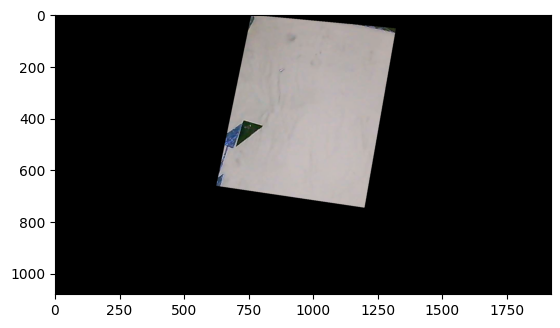

In [7]:
if __name__ == "__main__":
    for i in range(2):
        cm.cycle()
        sleep(1)
    plt.imshow(cc.cameras['0'].cropToActiveZone(cc.cameras['0'].mostRecentFrame))

Change failed: 'CalibrationObserver' object has no attribute 'trackingMode'


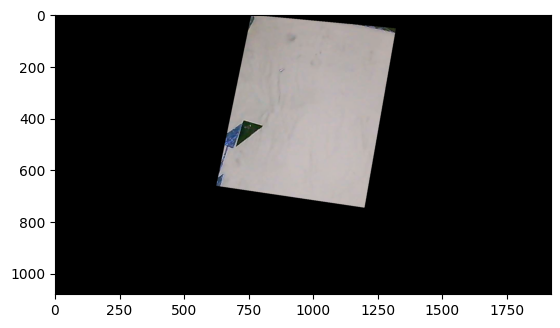

In [8]:
if __name__ == "__main__":
    try:
        c = cm.cycleForChange()
        plt.imshow(c.visual())
    except Exception as e:
        print(f"Change failed: {e}")
        plt.imshow(cc.cameras['0'].cropToActiveZone(cc.cameras['0'].mostRecentFrame))

In [9]:
class CalibratedCaptureConfiguration(CaptureConfiguration):
    def buildConfiguration(self):
        config = super().buildConfiguration()
        if self.rsc is not None:
            config['rsc'] = [[cN, 
                             [[a.tolist() if type(a) != list else a for a in coordList[0]],
                              [a.tolist() if type(a) != list else a for a in coordList[1]]]]
                            for cN, coordList in self.rsc.realCamSpacePairs]
        return config

    def loadConfiguration(self):
        super().loadConfiguration()
        config = self.readConfigFile()
        self.rsc = config.get("rsc", None)
        if self.rsc is not None:
            self.rsc = [
                [cN, [[np.array(pt, dtype="int32") for pt in cL] for cL in coordList]]
                for cN, coordList in self.rsc]
            self.rsc = RealSpaceConverter(self.rsc)
  
    def objectToHull(self, obj: TrackedObject, color=(255, 255, 255)):
        assert self.rsc is not None, "Calibration information needed"
        newContour = {
            camName: np.array([
                [[self.rsc.camCoordToRealSpace(camName, pt[0])]
                for cnt in cS.changeContours for pt in cnt]], dtype="int32")
            for camName, cS in obj.changeSet.items() if cS.changeType in ['add', 'move']}
    
        contourBase = np.zeros([1200, 1200], dtype="uint8")
        contourOverlap = None
        cSDeltas = self.rsc.changeSetCenterDeltas(obj)
        for index, (camName, contours) in enumerate(newContour.items()):
            tx, ty = cSDeltas[camName]
            M = np.float32([[1, 0, tx], [0, 1, ty]])
            for cnt in contours:
                filledContour = cv2.drawContours(contourBase.copy(), [cnt], -1, 255, -1)
                shiftedFilledContour = cv2.warpAffine(filledContour, M, (1200, 1200))
                if contourOverlap is None:
                    contourOverlap = shiftedFilledContour
                else:
                    contourOverlap = cv2.bitwise_or(contourOverlap, shiftedFilledContour)
        contours, _ = cv2.findContours(contourOverlap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hull = cv2.convexHull(contours[-1])
        return hull

    def buildMiniMap(self, yellowObjects=None, blueObjects=None, greenObjects=None):
        image = np.zeros([1200, 1200, 3], dtype="uint8")
        if self.rsc is None:
            return image
        try:
            if self.realSpaceContours is None:
                self.realSpaceContours = self.rsc.cameraRealSpaceOverlap(self.cameras)
                x, y, w, h = 1200, 1200, 1, 1
                for contour in self.realSpaceContours:
                    cbX, cbY, cbW, cbH = cv2.boundingRect(contour)
                    cb_maxX = cbX + cbW
                    cb_maxY = cbY + cbH
                    x = min(x, cbX)
                    y = min(y, cbY)
                    w = max(w, cb_maxX - x)
                    h = max(h, cb_maxY - y)
                self.realSpaceBoundingBox = x, y, w, h
        except Exception as e:
            print(e)
            self.realSpaceContours = None
            return image
        x, y, w, h = self.realSpaceBoundingBox

        yellowObjects = [] if yellowObjects is None else yellowObjects
        blueObjects = [] if blueObjects is None else blueObjects
        greenObjects = [] if greenObjects is None else greenObjects
        objsAndColors = \
              [[yellowies, (0, 255, 255)] for yellowies in yellowObjects] \
            + [[blueies, (255, 0, 0)] for blueies in blueObjects] \
            + [[greenies, (0, 255, 0)] for greenies in greenObjects]

        if len(objsAndColors) == 0:
            return image[y:y+h, x:x+w]
        drawnObjs = []
        for obj, color in objsAndColors[::-1]:
            if obj in drawnObjs:
                continue
            drawnObjs.append(obj)
            hull = self.objectToHull(obj)
            image = cv2.drawContours(image, [hull], -1, color, -1)
        return image[y:y+h, x:x+w]

In [10]:
class CalibratedObserver(Observer):
    def __init__(self, config: CalibratedCaptureConfiguration):
        super().__init__(config)